We will use the starter notebook to the Kaggle Competition as reference for our initial implementation

# Import Libraries

In [1]:
import os
print(os.getcwd())

/content


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import librosa
import IPython.display as ipd
import librosa.display as lid
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')

ModuleNotFoundError: No module named 'keras_cv'

## Library Version

In [ ]:
import keras_cv
import keras
import keras.backend as K
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)


# Configuration

You will need to change the paths to your local directories

In [ ]:
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 10
    preset =  "efficientnetv2_b0_imagenet"

    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir(r"C:/Users/oki08/Downloads/BirdClef_2024/train_audio")) # Change this  path
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Dataset Path

In [ ]:
BASE_PATH = r"C:/Users/oki08/Downloads/BirdClef_2024"

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

## Utility

In [ ]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

In [ ]:
row = df.iloc[35]

# Display audio
display_audio(row)

# Data Split  

Since we do not have access to the testing set, we will split training into two and treat validation set as test set initially

In [ ]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Data Loader

## Decoders

Here, we will take inspiration from other previous implementation regarding decoding .ogg files as they are good practices. For example, we will change from stereo to mono and standardize the length as well as generate mel spectograms with 3 channels to match ImageNet. Decoding is done using librosa package.


In [ ]:
import librosa
import tensorflow as tf

def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        def _load_audio(path):
            # Convert the path tensor to a string
            path = tf.compat.as_str_any(path.numpy())
            # Load the audio file with librosa
            audio, _ = librosa.load(path, sr=CFG.sample_rate, mono=True)
            return audio

        # Use tf.py_function to execute _load_audio in eager mode
        audio = tf.py_function(_load_audio, [filepath], tf.float32)
        return tf.reshape(audio, [-1])  # Ensure it has a 1D shape

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len:
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = crop_or_pad(audio, dim)

        # Compute Mel spectrogram with librosa
        def _compute_mel_spec(audio):
            mel_spec = librosa.feature.melspectrogram(
                y=audio.numpy(),
                sr=CFG.sample_rate,
                n_fft=CFG.nfft,
                hop_length=CFG.hop_length,
                n_mels=CFG.img_size[0]
            )
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            return mel_spec

        mel_spec = tf.py_function(_compute_mel_spec, [audio], tf.float32)
        mel_spec = apply_preproc(mel_spec)
        mel_spec = tf.tile(mel_spec[..., None], [1, 1, 3])
        mel_spec = tf.image.resize(mel_spec, CFG.img_size)
        return mel_spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


## Augmenters
We will apply augmentations to spectrogram data by usingMixUp, CutOut (TimeMasking and FreqMasking in this case) from KerasCV for this initial implementation. We plan to experiment with other augmentation techniques later in the project but from looking at related work regarding CNNs, these seems to work the best and will be a good initial starting point to expriment with.

In [ ]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment

## Data Pipeline
We will use the tf.dataset package to build a datapipeline incorporating different paths to the audio files

In [ ]:
def build_dataset(paths, labels=None, batch_size=32,
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Datasets

In [ ]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Visualization
Generate **spectrogram** and its associate **label**

In [ ]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]),
                     n_fft=CFG.nfft,
                     hop_length=CFG.hop_length,
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

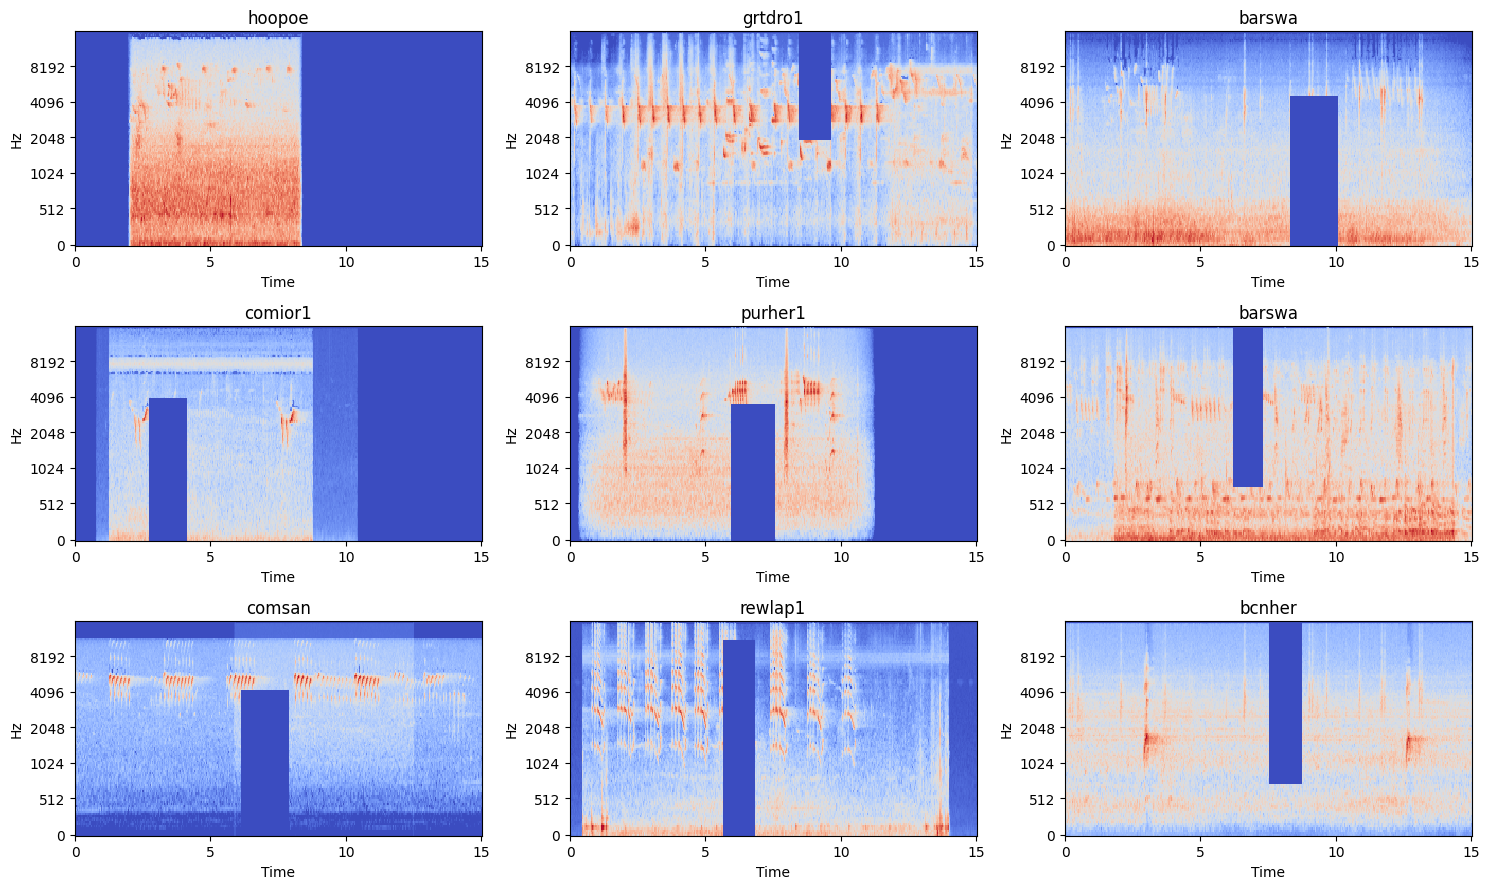

In [ ]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)

# Build Models

To perform the audio recognition task, I will utilize the `EfficientNetV2` ImageNet-pretrained model as a base implementation and fine tune using our data. Even though EfficientNetV2 is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

 In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a large length .


In [ ]:
print(keras_cv.models.EfficientNetV2Backbone.presets)

{'efficientnetv2_s': {'metadata': {'description': 'EfficientNet architecture with 6 convolutional blocks.', 'params': 20331360, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_s/2'}, 'efficientnetv2_m': {'metadata': {'description': 'EfficientNet architecture with 7 convolutional blocks.', 'params': 53150388, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_m/2'}, 'efficientnetv2_l': {'metadata': {'description': 'EfficientNet architecture with 7 convolutional blocks, but more filters the in `efficientnetv2_m`.', 'params': 117746848, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_l/2'}, 'efficientnetv2_b0': {'metadata': {'description': 'EfficientNet B-style architecture with 6 convolutional blocks. This B-style model has `width_coefficient=1.0

In [ ]:
from tensorflow import keras
import keras_cv

# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))

# Load the pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)

# Stack custom layers on top of the backbone
x = backbone(inp, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
out = keras.layers.Dense(CFG.num_classes, activation="softmax")(x)

# Build the model
model = keras.models.Model(inputs=inp, outputs=out)

# Compile the model
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name='auc')],
)

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 182)                 │         233,142 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,152,454 (23.47 MB)

 Trainable params: 6,091,846 (23.24 MB)

 Non-trainable params: 60,608 (236.75 KB)

# LR Schedule
* Learning Rate scheduler for transfer learning.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 4e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 4, 0, 0.9

    def lrfn(epoch):  # Learning rate update
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  =
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

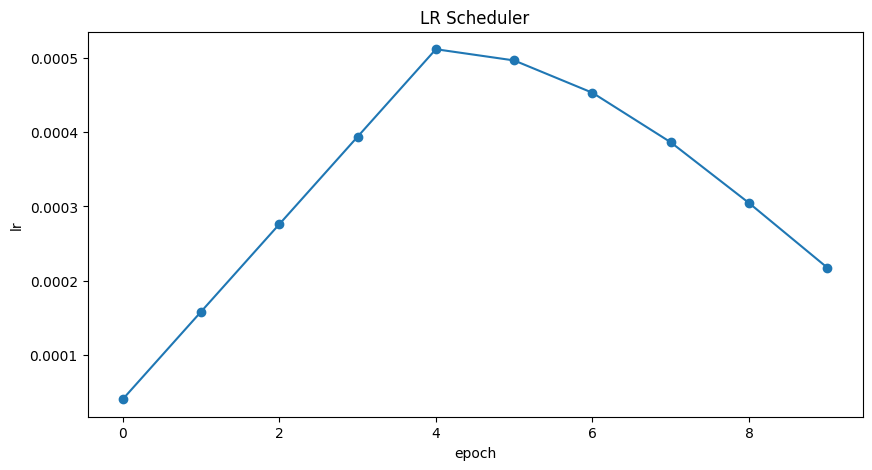

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

## Training using transfer learning

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
import tensorflow as tf
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())


Is TensorFlow built with CUDA? False


In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    verbose=1
)

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - auc: 0.8834 - loss: 1.7199 - val_auc: 0.9661 - val_loss: 1.5885 - learning_rate: 4.0000e-05
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - auc: 0.8863 - loss: 1.6629 - val_auc: 0.9666 - val_loss: 1.5353 - learning_rate: 1.5800e-04
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - auc: 0.8724 - loss: 1.6738 - val_auc: 0.9667 - val_loss: 1.5057 - learning_rate: 2.7600e-04
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - auc: 0.8729 - loss: 1.5595 - val_auc: 0.9643 - val_loss: 1.4792 - learning_rate: 3.9400e-04
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - auc: 0.8851 - loss: 1.4061 - val_auc: 0.9650 - val_loss: 1.4633 - learning_rate: 5.1200e-04
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - auc: 0.8957 - loss: 1.2439 - val_auc: 0.9635 - val_loss: 1.4351 - learning_rate: 4.9686e-04
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - auc: 0.8915 - loss: 1.1378 - val_auc: 0.9600 - val_loss: 1.4304

## Result Summary

In [ ]:
best_epoch = np.argmax(history.history["val_auc"])
best_score = history.history["val_auc"][best_epoch]
print('>>> Best AUC: ', best_score)
print('>>> Best Epoch: ', best_epoch+1)

>>> Best AUC:  0.9666696786880493
>>> Best Epoch:  3
